In [29]:
import copy
import sys
sys.path.insert(0, "..")
from classes.atoms import Atom, Atom_Collection, create_atom_col_copies
from classes.calculators.lennardjones import LennardJones
from classes.optimizers.random_struct_search import Line_searcher
from classes.optimizers.md_simulator import MDTP_Simulator as MD_sim
import numpy as np
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

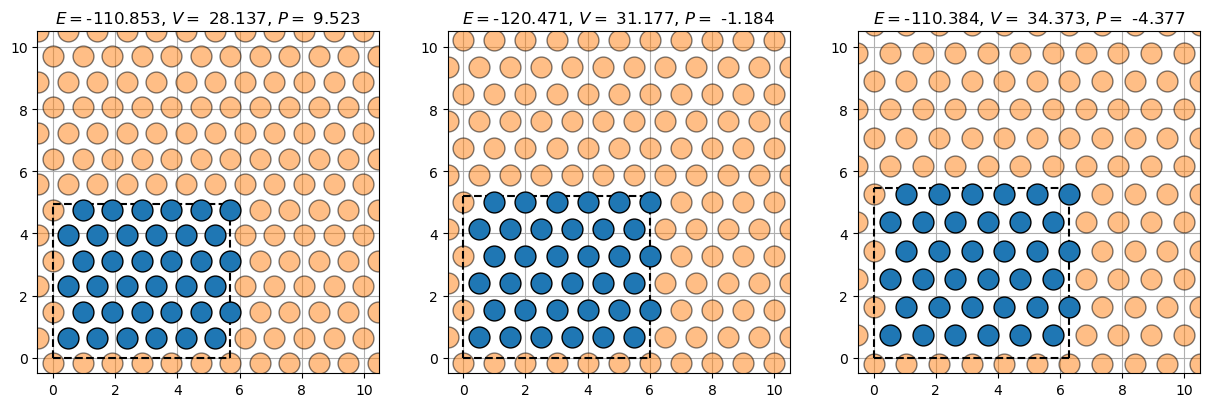

In [45]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

unit_cell = (np.array([2.0, 0.0]), np.cos(np.pi/6.0)*np.array([0.0,2.0]))
atom_poses = [np.array([0.0,0.0]), np.array([0.5,0.5]), np.array([1.0,0.0]), np.array([1.5,0.5])]
atom_col = Atom_Collection(atomlist=[Atom(position=pos, size=30) for pos in atom_poses], unit_cell=unit_cell, pbc=True)
atom_col.calculator = LennardJones(eps0=1.0, pbc=atom_col.pbc, pbc_handler=atom_col.pbc_handler)
optimizer = Line_searcher(atom_col=atom_col)
pos_opt, f = optimizer.run(fmax=0.05)
opt_col = create_atom_col_copies(atom_col=atom_col, positions=pos_opt, velocities=np.zeros(shape=pos_opt.shape))[0]
l1, l2 = unit_cell
new_poses = []
for i in [0.0, 1.0, 2.0]:
    for j in [0.0, 1.0, 2.0]:
        disp_pos = pos_opt + l1*i + l2*j
        new_poses.append(disp_pos)

unit_cell = (np.array([6.0, 0.0]), 3*np.cos(np.pi/6.0)*np.array([0.0,2.0]))
scaling_factors = [-0.05, 0.0, 0.05]
scaled_cols = []
for ax, scaling_factor in zip(axs, scaling_factors):
    ax.set_xlim([-0.5,10.5])
    ax.set_ylim([-0.5,10.5])
    ax.grid()
    ax.set_aspect("equal")
    atom_col = Atom_Collection(atomlist=[Atom(position=pos, size=20) for pos in np.array(new_poses).reshape(6**2, 2)], unit_cell=unit_cell, pbc=True)
    atom_col.calculator = LennardJones(eps0=1.0, pbc=atom_col.pbc, pbc_handler=atom_col.pbc_handler)
    atom_col.scale_volume(scale_x=scaling_factor, scale_y=scaling_factor)
    vol = atom_col.volume
    p = atom_col.get_pressure(step_size=1e-4)
    ax.set_title(rf"$E = ${atom_col.get_potential_energy().round(3)}, $V = $ {vol.round(3)}, $P = $ {p.round(3)}")
    atom_col.plot_cells(ax=ax, size=15)
    atom_col.reset_plot_axes()
    scaled_cols.append(atom_col)

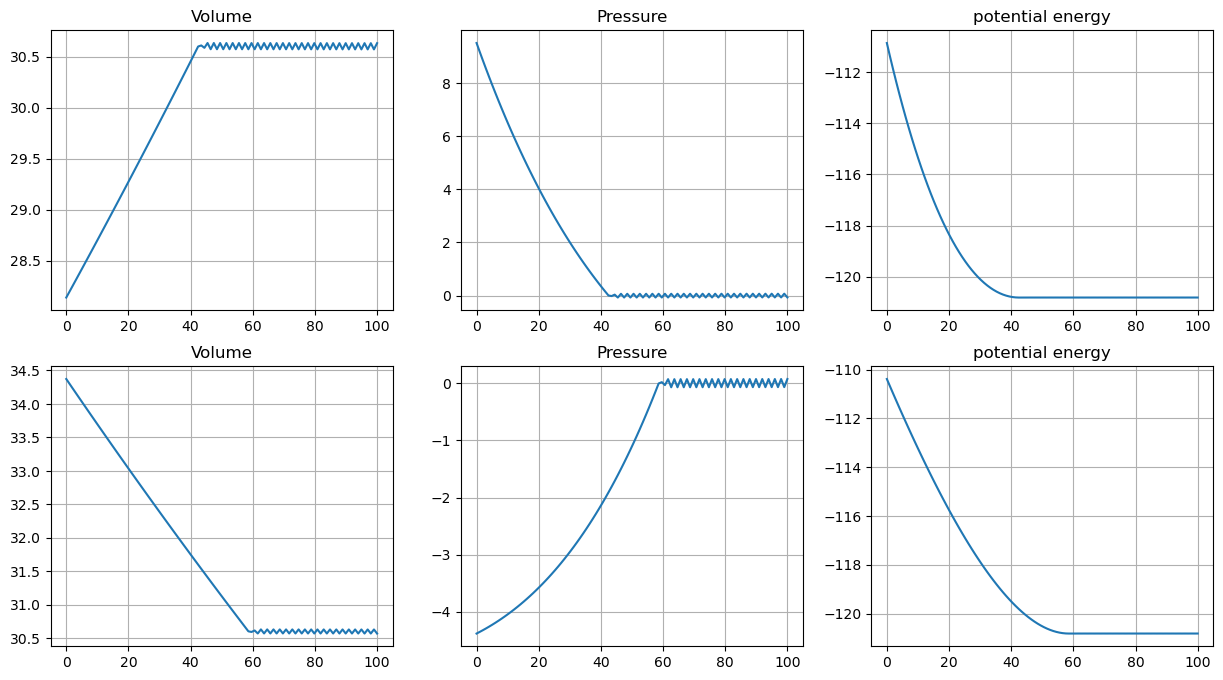

In [46]:
fig, axs = plt.subplots(2,3, figsize=(15,8))

for ax in axs.flatten():
    ax.grid()

poses_for_plot_test = []
unit_cells = []
for i, scaled_col in enumerate([scaled_cols[0], scaled_cols[2]]):
    md_simulator = MD_sim(atom_col=scaled_col, temp=0.00, time_step=0.001, step_size=1e-3, gamma=1e-3)
    Es, poses, vels, stresses, vols = md_simulator.run_MD_simulation(N_steps=100, reset_unit_cell=False)
    poses_for_plot_test.append(poses[-1][-1])
    unit_cells.append([md_simulator.pbc_handler.v1*1.0, md_simulator.pbc_handler.v2*1.0])
    pressures_tot = []
    volumes_tot = []
    energies_tot = []
    for j in range(len(stresses)):
        volumes = []
        pressures = []
        energies = []
        for stress, vol, E in zip(stresses[j], vols[j], Es[j]):
            energies.append(E)
            volumes.append(vol)
            pressures.append(np.mean(stress.diagonal())/vol)
        volumes_tot.append(np.mean(volumes))
        pressures_tot.append(np.mean(pressures))
        energies_tot.append(np.mean(energies))
    xs = np.linspace(0.0, len(energies_tot),len(energies_tot))
    axs[i][0].set_title("Volume")
    axs[i][1].set_title("Pressure")
    axs[i][2].set_title("potential energy")
    axs[i][0].plot(xs, volumes_tot)
    axs[i][1].plot(xs, pressures_tot)
    axs[i][2].plot(xs, energies_tot)

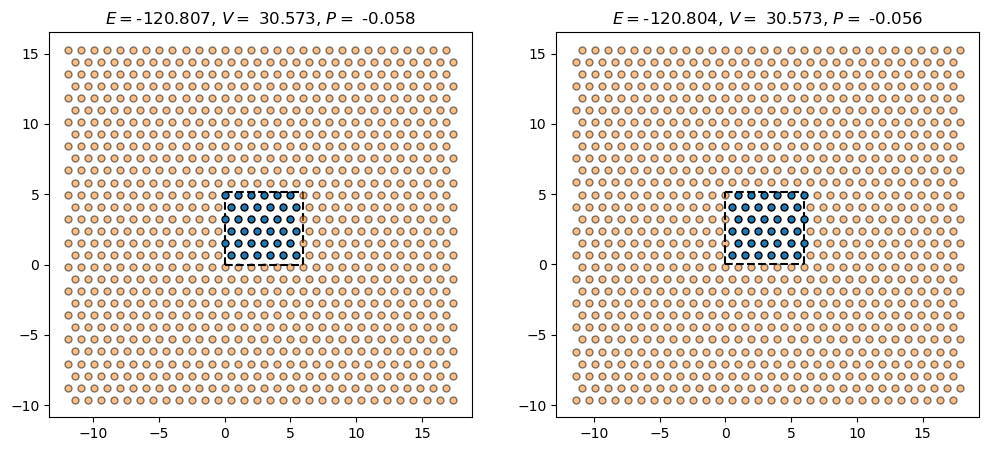

In [47]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
for poses,unit_cell, ax in zip(poses_for_plot_test, unit_cells, axs):
    atomlist = [Atom(position=pos) for pos in poses]
    p0_col = Atom_Collection(atomlist=atomlist, unit_cell=(unit_cell[0], unit_cell[1]), pbc=True)
    p0_col.calculator = LennardJones(eps0=1.0, pbc_handler=md_simulator.pbc_handler, pbc=True)
    p = p0_col.get_pressure(step_size=1e-4)
    ax.set_title(rf"$E = ${p0_col.get_potential_energy().round(3)}, $V = $ {vol.round(3)}, $P = $ {p.round(3)}")
    p0_col.plot_cells(ax=ax, size=5)
    p0_col.reset_plot_axes()

In [50]:
temps = [0.40]
vols_total = []
pressures_total = []
energies_total = []
positions_total = []
md_simulator = MD_sim(atom_col=p0_col, temp=0.15, time_step=0.001, step_size=1e-3, gamma=1e-3)
for temp in temps:
    md_simulator.temp=temp
    Es, poses, vels, stresses, vols = md_simulator.run_MD_simulation(N_steps=400, reset_unit_cell=False)
    positions_total.append(poses)
    pressures_tot = []
    volumes_tot = []
    energies_tot = []
    for j in range(len(stresses)):
        volumes = []
        pressures = []
        energies = []
        for stress, vol, E in zip(stresses[j], vols[j], Es[j]):
            energies.append(E)
            volumes.append(vol)
            pressures.append(np.mean(stress.diagonal())/vol)
        volumes_tot.append(np.mean(volumes))
        pressures_tot.append(np.mean(pressures))
        energies_tot.append(np.mean(energies))
    vols_total.append(volumes_tot)
    pressures_total.append(pressures_tot)
    energies_total.append(energies_tot)

KeyboardInterrupt: 

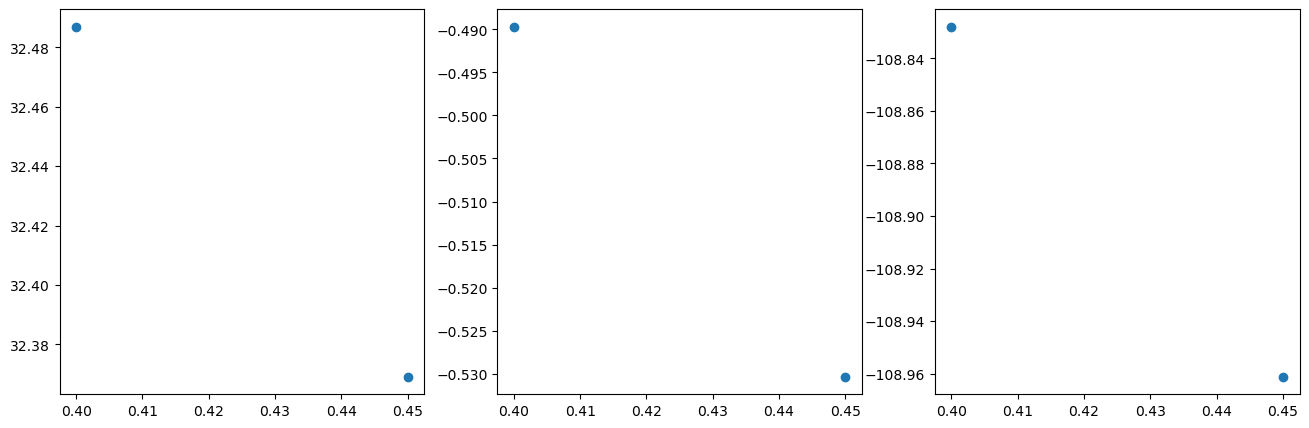

[-120.82059973887102, -115.1397683030151, -106.2802758237066, -106.46163998672911, -107.09821677327612, -107.45294396645096, -107.96774577024763, -108.89755792571557, -105.47934840165472, -101.00633072162826, -102.51490458438386, -104.36764570432308, -99.26630333899031, -99.30692235633997, -100.84053766548192, -99.70447997142, -99.30549918975657, -99.4228489007947, -100.28514152361815, -101.84267994596603, -97.7771640507472, -100.28415906358084, -102.22469987099801, -97.10956755353436, -99.69153272957138, -101.70475674488415, -97.86714755458748, -100.58063998376589, -100.58642040720645, -101.51832842951481, -99.8017034569766, -101.45723847774923, -102.2332667179445, -101.51240141511947, -102.17623417659773, -103.70092808264562, -104.12538434477351, -102.06640564072137, -101.60261208086696, -100.33075786149766, -99.43214774868316, -99.06378589728587, -101.1670664875532, -103.03809233440124, -106.98196226937945, -104.31681529014485, -98.78489789664732, -97.3239347522021, -97.637094657661